In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

# sample a random distribution
d50 = 10/1e6

a50 = d50/2
std = 1

number_of_particles = 1e6
mean = np.log(a50)
radii = np.random.lognormal(mean, std, int(number_of_particles))


# set sediment density
density = 2650  # kg/m**3

# calculate the mass concentration assuming unit volume
mass_concentration = np.sum(4/3*np.pi*density*radii**3)  # kg/m**3
mass_concentration*1e3  # mg/L

0.11859724795913285

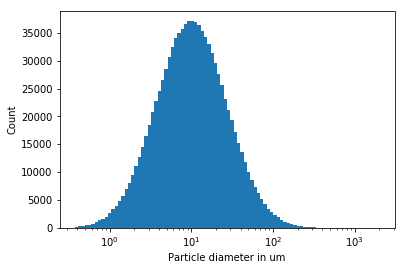

In [2]:
# bin the radii using lab bins
bin_edges = np.logspace(np.log10(0.375124), np.log10(2000), num=93)/2/1e6
particle_count, bin_edges = np.histogram(radii, bins=bin_edges)

bin_widths = np.diff(bin_edges)
_ = plt.bar(2*bin_edges[:-1]*1e6, particle_count, 2*bin_widths*1e6, align='edge')
plt.xscale('log')
_ = plt.xlabel('Particle diameter in um')
_ = plt.ylabel('Count')

### Sum of backscatter from individual particles
$$\sum\limits_{i=1}^n\frac{f_i^2a_i^2}{4}$$

In [3]:
from said.sedimentacousticdistribution import form_function

# set the acoustic instrument frequency
frequency = 1200  # kHz

# calculate the backscatter from all of the individual particles
particle_form_function = form_function(2*radii, frequency)
particle_backscatter = particle_form_function**2 * radii**2/4
particle_backscatter.sum()

2.5249711128129337e-06

### Sum of total backscatter from each bin
With $n$ bins and $N$ particles in each bin
$$\sum\limits_{i=1}^n\frac{N_if_i^2a_i^2}{4}$$

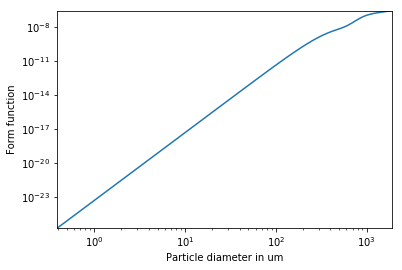

In [4]:
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_form_function = form_function(2*bin_centers, frequency)
bin_backscatter = bin_form_function**2 * bin_centers**2/4

# plot the form function
plt.plot(2*bin_centers*1e6, bin_backscatter)
plt.xlabel('Particle diameter in um')
plt.ylabel('Form function')
plt.xscale('log')
plt.yscale('log')
plt.autoscale(tight=True)

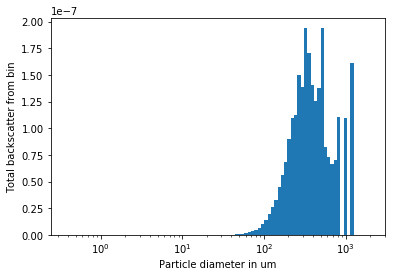

In [5]:
total_bin_backscatter = bin_backscatter * particle_count
_ = plt.bar(2*bin_edges[:-1]*1e6, total_bin_backscatter, 2*bin_widths*1e6, align='edge')
plt.xlabel('Particle diameter in um')
plt.ylabel('Total backscatter from bin')
plt.xscale('log')

In [6]:
total_bin_backscatter.sum()

2.5363997974821726e-06

### Total concentration and mean form function

$$\frac{3M\langle f\rangle^2}{8\pi\rho_s\langle d\rangle}$$

In [7]:
from said.sedimentacousticdistribution import SedimentAcousticDistribution
from said.sedimentsizedistribution import SedimentSizeDistribution

# convert to volume CDF
bin_particle_volumes = 4/3*np.pi*bin_centers**3
bin_volumes = particle_count*bin_particle_volumes
cumulative_volume = np.cumsum(bin_volumes)
cumulative_volume = np.insert(cumulative_volume, 0, 0)
volume_cdf = cumulative_volume/np.sum(bin_volumes)

# initialize a SedimentSizeDistribution class and get the number CDF
sediment_size_distribution = SedimentSizeDistribution(2*bin_edges, volume_cdf)

mean_form_function = SedimentAcousticDistribution(sediment_size_distribution).form_function(frequency)
mean_diameter = sediment_size_distribution.mean('number')
mean_backscatter = mean_form_function**2 * (3/8*1/np.pi*mass_concentration/(mean_diameter*density))
mean_backscatter

2.5231050819864941e-06

### Sum of concentration and mean form function for each bin

$$\sum\limits_{i=1}^n\frac{3M_i\langle f\rangle_i^2}{16\pi\rho_s\langle a\rangle_i}$$

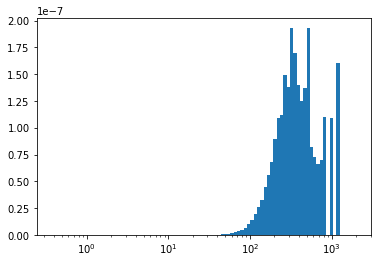

In [8]:
cdf_diameters, cdf = sediment_size_distribution.cdf('volume')
distribution_fraction = np.diff(cdf)

bin_concentration = mass_concentration*distribution_fraction

backscatter = bin_form_function**2 * (3/16*1/np.pi*bin_concentration/(bin_centers*density))

_ = plt.bar(2*bin_edges[:-1]*1e6, backscatter, 2*bin_widths*1e6, align='edge')
plt.xscale('log')

In [9]:
backscatter.sum()

2.5231050818279024e-06